<a href="https://colab.research.google.com/github/sdthtp/trafficSignClassification/blob/master/Traffic_Sign_Classification_own_Model_Sedat_Hatip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import zipfile
import pandas as pd
import tensorflow as tf
from tensorflow import keras # Tensorflow high-level api
from tensorflow.keras import layers
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense,Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, Conv2D,MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
#from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from datetime import datetime

Using TensorFlow backend.


In [2]:
!pip install kaggle

In [3]:
!cat > kaggle.json <<EOF
!echo '{"username":"hatipsedat","key":"645cde903abbd80d20dcaaa40b4ebe1d"}' > kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

/bin/bash: warning: here-document at line 0 delimited by end-of-file (wanted `EOF')


In [4]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 611M/612M [00:10<00:00, 64.2MB/s]
100% 612M/612M [00:10<00:00, 59.3MB/s]


In [5]:
local_zip = '/content/gtsrb-german-traffic-sign.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/gtsrb')
zip_ref.close()

In [6]:
# Generiere Bündel (batches) von Bilddaten-Tensoren mit echtzeit Datenaugmentierung.
# Die Daten werden in Bündel durchgelaufen (loop over in batches).
# 20 Prozent der Daten werden f ür die Validierung verwendet.


import cv2
trainfiles=open('/content/gtsrb/Train.csv').read().strip().split('\n')[1:] #Pro Zeile aufsplitten
#print(trainfile)
data=[]
labels =[]
IMG_PATH=[]
for i in range(len(trainfiles)):
    label,imagepath = trainfiles[i].split(',')[-2:] #Label und Imagepath aufsplitten
    imagepath=os.path.join("/content/gtsrb/",imagepath) #Path der CSV Datei dem Hauptpath anhängen
    IMG_PATH.append(imagepath) #PATH array jeweils alle paths hinzufügen
    image = cv2.imread(imagepath) #foto lesen
    image = cv2.resize(image,(32,32)) #trivial
    b,g,r = cv2.split(image)           
    image = cv2.merge([r,g,b]) #OpenCV liest Bilder im BGR Channel (warum auch immer), deshalb musste der Channel hier in RGB umgeändert werden
    data.append(image) #data array alle bilder hinzufügen
    labels.append(label) #die zugehörigen labels

    #IMG_PATH[image1.path, image2.path, image2.path, ..., imageN.path]
    #data[image1, image2, image3, ..., imageN]
    #labels[20, 10, 30, ..., label von imageN]


/content/gtsrb/Train/1/00001_00047_00020.png


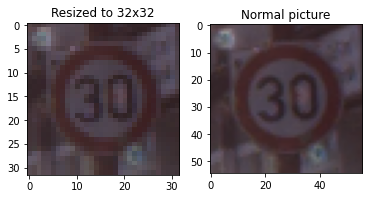

In [7]:
print(IMG_PATH[2000])
plt.subplot(1,2,1)
plt.title("Resized to 32x32")
plt.imshow(data[2000])
plt.subplot(1,2,2)
plt.title("Normal picture")
plt.imshow(plt.imread(IMG_PATH[2000]))
plt.show()

In [8]:
train_x, train_y = data,labels
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y,
                                                    stratify=train_y, 
                                                    test_size=0.2,
                                                    random_state = 7)
train_x = np.array(train_x)
train_y = np.array(train_y)
valid_x = np.array(valid_x)
valid_y = np.array(valid_y)
print(train_y.shape[0])
print(valid_y.shape[0])

31367
7842


In [19]:
counter = 0
piccounttotal = [210,2220,2250,1410,1980,1860,420,1440,1410,1470,2010,1320,2100,2160,780,630,420,1110,1200,210,360,330,390,510,270,1500,600,240,540,270,450,780,240,689,420,1200,390,210,2070,300,360,240,240]
#piccounttrain = piccounttotal * 0.8
#piccountvalid = piccounttotal * 0.2

test_list = [int(i) for i in train_y] 
print(sorted(set(test_list)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


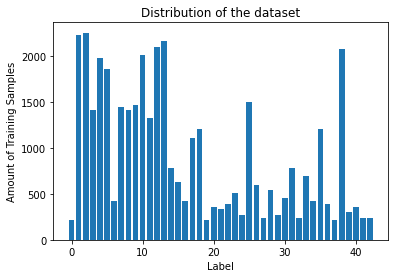

In [22]:
plt.bar(sorted(set(test_list)),piccount)
plt.title('Distribution of the dataset')
plt.ylabel('Amount of Training Samples')
plt.xlabel('Label')
plt.show()

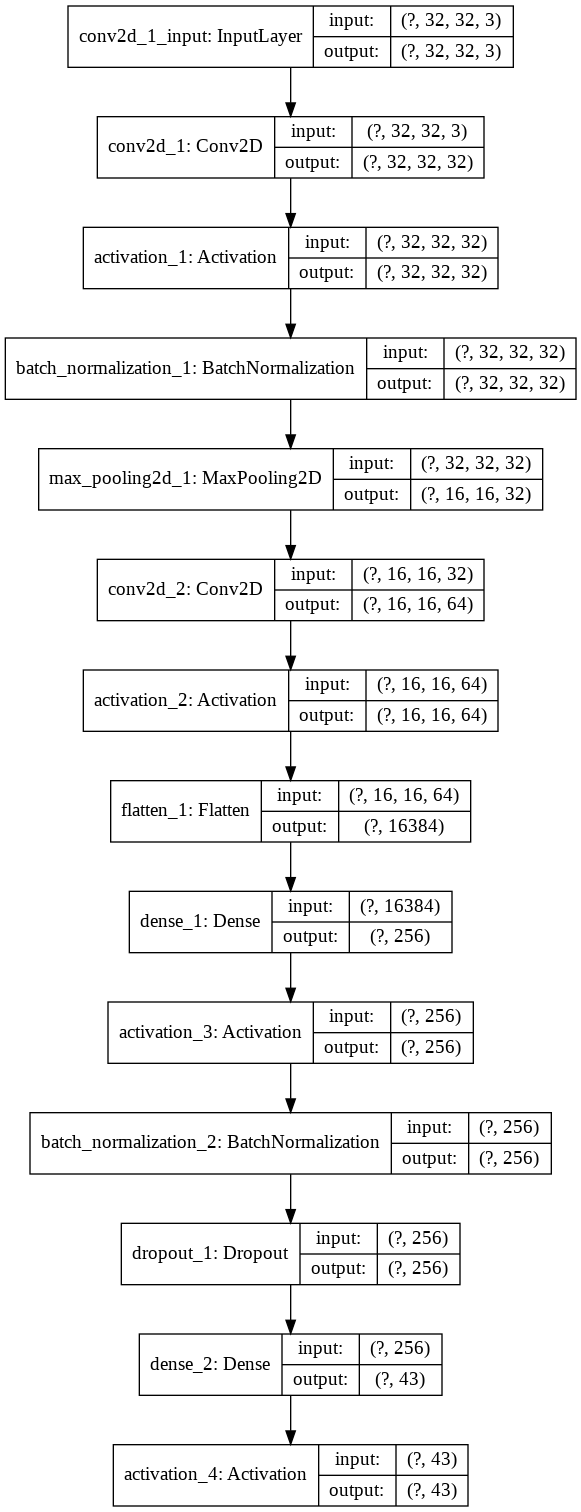

In [ ]:

model = Sequential()
inputShape = (32, 32,3)
model.add(Conv2D(32, (5, 5), padding="same",
input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(43))
model.add(Activation("softmax"))
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

In [ ]:
trainAugmentation = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        zoom_range=0.15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode="nearest"
)

In [ ]:
timestamp = datetime.now().strftime("%d-%b-%Y (%H:%M)")
filepath = "/content/drive/My Drive/own_model_v" + timestamp + ".h5"
loadpath = "/content/drive/My Drive/own_model_v14-Jul-2020 (03:04).h5"
model = load_model(loadpath)

In [ ]:
#Optimizer/Compiler Block:
const_learning_rate = 0.0015
const_epochNum = 200
print("[INFO] Kompilierung...")
#decay=const_learning_rate / (const_epochNum * 0.5)
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(lr=const_learning_rate, decay=(1./0.75 -1)/32),
metrics=["accuracy"])

[INFO] Kompilierung...


In [ ]:
#Callback Funktion um zu sehen, um wie viel die LR mit LR-Decay pro Epoche abnimmt, funktioniert allerdings nicht wie erwartet, sondern gibt immer die Konstante LR an...
class printlearningrate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = K.eval(optimizer.lr)
        Epoch_count = epoch + 1
        print('\n', "Epoch:", Epoch_count, ', LR: {:.10f}'.format(lr))
printlr = printlearningrate()

In [ ]:
#Trainingsblock
const_batch_size = 32
print("[INFO] Networktraining...")
print(model.optimizer.lr)
history = model.fit_generator(
	trainAugmentation.flow(train_x, train_y, batch_size=const_batch_size),
	validation_data=(trainAugmentation.flow(valid_x, valid_y, batch_size=const_batch_size)),
	steps_per_epoch=train_x.shape[0] // const_batch_size,
	epochs=const_epochNum,
	callbacks = [printlr],
	verbose=1)
model.save(filepath)

[INFO] Networktraining...
<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=0.0015>
Epoch 1/200
980/980 [==============================] - 31s 32ms/step - loss: 1.5119 - accuracy: 0.5776 - val_loss: 0.0681 - val_accuracy: 0.7863

 Epoch: 1 , LR: 0.0015000000
Epoch 2/200
980/980 [==============================] - 24s 24ms/step - loss: 0.6874 - accuracy: 0.8054 - val_loss: 0.0152 - val_accuracy: 0.8922

 Epoch: 2 , LR: 0.0015000000
Epoch 3/200
980/980 [==============================] - 24s 24ms/step - loss: 0.5244 - accuracy: 0.8545 - val_loss: 0.8455 - val_accuracy: 0.9123

 Epoch: 3 , LR: 0.0015000000
Epoch 4/200
980/980 [==============================] - 24s 25ms/step - loss: 0.4340 - accuracy: 0.8833 - val_loss: 0.1668 - val_accuracy: 0.9276

 Epoch: 4 , LR: 0.0015000000
Epoch 5/200
980/980 [==============================] - 24s 25ms/step - loss: 0.3815 - accuracy: 0.8963 - val_loss: 0.7699 - val_accuracy: 0.9454

 Epoch: 5 , LR: 0.0015000000
Epoch 6/200
980/980 [====

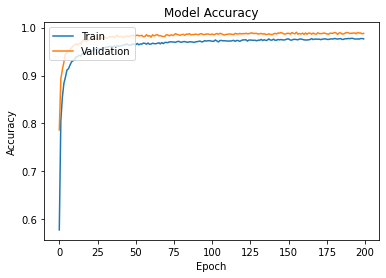

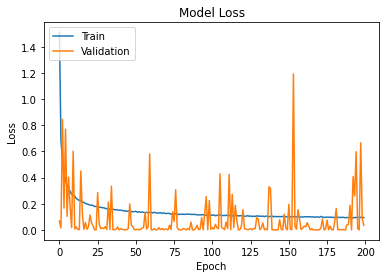

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
testfiles=open('/content/gtsrb/Test.csv').read().strip().split('\n')[1:] #Pro Zeile aufsplitten
data=[]
labels =[]
IMG_PATH=[]
for i in range(len(testfiles)):
    label,imagepath = testfiles[i].split(',')[-2:] #Label und Imagepath aufsplitten
    imagepath=os.path.join("/content/gtsrb/",imagepath) #Path der CSV Datei dem Hauptpath anhängen
    IMG_PATH.append(imagepath) #PATH array jeweils alle paths hinzufügen
    image = cv2.imread(imagepath) #foto lesen
    image = cv2.resize(image,(32,32)) #trivial
    b,g,r = cv2.split(image)           
    image = cv2.merge([r,g,b]) #OpenCV liest Bilder im BGR Channel (warum auch immer), deshalb musste der Channel hier in RGB umgeändert werden
    data.append(image) #data array alle bilder hinzufügen
    labels.append(label) #die zugehörigen labels

test_x, test_y = data,labels
test_x = np.array(test_x)
test_y = np.array(test_y)

In [ ]:
#Test_Data wird normalisiert für korrekte Evaluierung
test_augmented = np.zeros((test_x.shape[0],32,32,3))
for i in range(test_x.shape[0]):
  test_augmented[i] = test_x[i]/255.0
test_x = test_augmented

In [ ]:
#Um mit eigenen Bildern zu testen

"""
image = cv2.imread('/content/drive/My Drive/EigeneTests/sample1.PNG')
image = cv2.resize(image,(32,32)) #trivial
b,g,r = cv2.split(image)           
image = cv2.merge([r,g,b]) #OpenCV liest Bilder im BGR Channel (warum auch immer), deshalb musste der Channel hier in RGB umgeändert werden
image = np.array(image)
plt.imshow(image)
image = np.expand_dims(image, axis=0)
plt.show()
pred = model.predict(image/255)
print("Predicted Label: " + str(np.argmax(pred, axis=1)) + ". Confidence: " + str(pred[0][np.argmax(pred,axis=1)])) #argmax, da wir die Zeile mit der höchsten Wahrscheinlichkeit nehmen (softmax)
if (np.argmax(pred, axis=1) == 1):
  print("It is a 30km/h speed limit sign!")
else:
  print("It is another sign")

"""

'\nimage = cv2.imread(\'/content/drive/My Drive/EigeneTests/sample1.PNG\')\nimage = cv2.resize(image,(32,32)) #trivial\nb,g,r = cv2.split(image)           \nimage = cv2.merge([r,g,b]) #OpenCV liest Bilder im BGR Channel (warum auch immer), deshalb musste der Channel hier in RGB umgeändert werden\nimage = np.array(image)\nplt.imshow(image)\nimage = np.expand_dims(image, axis=0)\nplt.show()\npred = model.predict(image/255)\nprint("Predicted Label: " + str(np.argmax(pred, axis=1)) + ". Confidence: " + str(pred[0][np.argmax(pred,axis=1)])) #argmax, da wir die Zeile mit der höchsten Wahrscheinlichkeit nehmen (softmax)\nif (np.argmax(pred, axis=1) == 1):\n  print("It is a 30km/h speed limit sign!")\nelse:\n  print("It is another sign")\n\n  '

In [ ]:
#Evaluierung
evaluation = model.evaluate(
    x=test_x, y=test_y, batch_size=const_batch_size, verbose=1, sample_weight=None, steps=None,
  callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False
)
sampleExcelRow = 55
#pred = model.predict(image/255)
pred = model.predict(test_x[sampleExcelRow - 2:sampleExcelRow - 1]) #9:10 = 11 in excel
print(model.metrics_names)
print(evaluation)
arg = np.argmax(pred, axis = 1)
print(arg) #printet das label der 55 excel reihe in Test.csv

12630/12630 [==============================] - 1s 115us/step
['loss', 'accuracy']
[0.22441401230562139, 0.9320665001869202]
[9]
